<a href="https://colab.research.google.com/github/Kat-ies/Coursework/blob/faster_rcnn/face_detection/Face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!git clone https://github.com/Kat-ies/Coursework.git
!git clone --single-branch --branch faster_rcnn https://github.com/Kat-ies/Coursework.git
%cd Coursework/src
%run for_google_drive.py

# **Retrain Faster-RCNN**

Здесь будет небольшой рассказ про основную идею: поработать с Faster-RCNN. А точнее указание, что дя начала мы возьмём предобученную модель и дообучим на своих данных (с указанием размера выборки, настроек inetunning и тд..).

In [2]:
from face_detection.retrain_model import retrain_model
retrain_model()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



Epoch: [0]  [   0/1124]  eta: 1:51:44  lr: 0.000001  loss: 2.6664 (2.6664)  loss_classifier: 0.7830 (0.7830)  loss_box_reg: 0.5717 (0.5717)  loss_objectness: 0.9809 (0.9809)  loss_rpn_box_reg: 0.3308 (0.3308)  time: 5.9647  data: 4.7922  max mem: 2905
Epoch: [0]  [ 100/1124]  eta: 0:11:27  lr: 0.000051  loss: 0.8725 (0.9514)  loss_classifier: 0.2305 (0.2963)  loss_box_reg: 0.4386 (0.2951)  loss_objectness: 0.1074 (0.2513)  loss_rpn_box_reg: 0.0579 (0.1088)  time: 0.5942  data: 0.0439  max mem: 4198
Epoch: [0]  [ 200/1124]  eta: 0:09:58  lr: 0.000101  loss: 0.4242 (0.8356)  loss_classifier: 0.1126 (0.2360)  loss_box_reg: 0.2139 (0.3155)  loss_objectness: 0.0641 (0.1981)  loss_rpn_box_reg: 0.0105 (0.0859)  time: 0.6344  data: 0.0433  max mem: 4529
Epoch: [0]  [ 300/1124]  eta: 0:08:59  lr: 0.000151  loss: 0.7626 (0.8043)  loss_classifier: 0.1479 (0.2209)  loss_box_reg: 0.3436 (0.3269)  loss_objectness: 0.0908 (0.1669)  loss_rpn_box_reg: 0.0785 (0.0896)  time: 0.6954  data: 0.0451  max m

# **Test retrained model**

Здесь будет рассказ про mean average precision + выводы

In [3]:
from data_loader import load_model
from face_detection.bounding_box import BoundingBox
from face_detection.bounding_boxes import BoundingBoxes
from face_detection.utils import CoordinatesType, BBType, BBFormat
from constants import *
import face_detection.evaluator as eval 
from face_detection.train_test_samples import make_samples 
from face_detection.transforms import test_transforms
import torch


def add_boxes(test_dicts, my_bounding_boxes, model=load_model(trained=True, mode='ADMIN')):

    dict_images = test_dicts[0]
    dict_frames = test_dicts[1]

    for key, rects in dict_frames.items():

        # let's add ground_truth_boxes first
        for rectangle in rects:
            x,y,w,h = rectangle
            gt_bounding_box = BoundingBox(imageName=key, classId='face', x=x, y=y,
                                w=w, h=h, typeCoordinates=CoordinatesType.Absolute,
                                bbType=BBType.GroundTruth, format=BBFormat.XYWH,
                                imgSize=dict_images[key].size)
            my_bounding_boxes.addBoundingBox(gt_bounding_box) 
            #print(rectangle)
            #print(gt_bounding_box.getAbsoluteBoundingBox())


        # now let's make predictions and add to our boxes all detected boxes
        image = test_transforms(dict_images[key])
        
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        
        with torch.no_grad():
            prediction = model([image.to(device)])

        boxes = list(prediction[0]['boxes'].cpu().numpy())
        scores = list(prediction[0]['scores'].cpu().numpy())
        
        for i, box in enumerate(boxes):

            x, y, x2, y2 = box
            detected_bounding_box = BoundingBox(imageName=key, classId='face', classConfidence=scores[i], 
                                        x=x, y=y, w=x2, h=y2, typeCoordinates=CoordinatesType.Absolute,
                                        bbType=BBType.Detected, format=BBFormat.XYX2Y2, imgSize=dict_images[key].size)
            my_bounding_boxes.addBoundingBox(detected_bounding_box)
            #print(box)
            #print(detected_bounding_box.getAbsoluteBoundingBox())

def show_retrain_results():
    my_bounding_boxes = BoundingBoxes()


    test_dicts = make_samples(mode='TEST')
    add_boxes(test_dicts, my_bounding_boxes)

    evaluator = eval.Evaluator()

    results = evaluator.PlotPrecisionRecallCurve(
        boundingBoxes=my_bounding_boxes, showGraphic=True,
        showInterpolatedPrecision=False, showAP=True)

    info = ['AP', 'total positives', 'total TP', 'total FP']


    for params in info:
        print(params + f": {results[0][params]}")

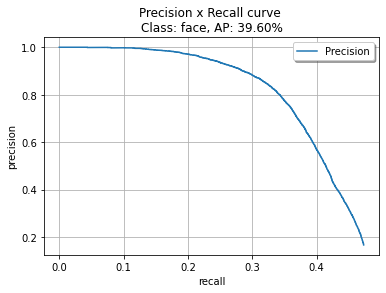

AP: 0.39598658314310187
total positives: 21954
total TP: 10390.0
total FP: 51883.0


In [4]:
show_retrain_results()

# **Examples**

Какие-нибудь слова про то, что "а давайте посмотрим на работу сетки в действии на авторских примерах".




In [5]:
from PIL import Image, ImageDraw 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from constants import *
import os
from data_loader import load_model


def show_predictions(images, predictions):

    fig = plt.figure(figsize=(60, 70))
    cols = 1
    rows = len(images)

    # ax enables access to manipulate each of subplots
    ax = []
    i = 0

   
    for image, prediction in zip(images, predictions):

        boxes = list(prediction[0]['boxes'].cpu().numpy())
        scores = list(prediction[0]['scores'].cpu().numpy())
        

        ax.append(fig.add_subplot(rows, cols, i + 1))
        i += 1

        for box, score in zip(boxes, scores):
            img1 = ImageDraw.Draw(image)   
            img1.rectangle(box, fill =None, outline ="red") 

            img2 = ImageDraw.Draw(image)
            img2.rectangle((box[0], box[1],
                            box[0] + SCORE_BACKGROUND_LABEL_WIDTH,
                            box[1] + SCORE_BACKGROUND_LABEL_HEIGHT),
                           fill ='black', outline ="black") 

            img3 = ImageDraw.Draw(image)
            img3.text((box[0],box[1]),'score: '+f"{score:.{2}f}")


        plt.imshow(image)

    plt.show()  # finally, render the plot


def show_image_examples():
    files = os.listdir(os.path.join(WORK_PATH, 'images'))
    files.sort()

    images = []
    predictions = []

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = load_model(trained=True, mode='ADMIN')

    for file in files:
        image = Image.open(os.path.join(WORK_PATH, 'images', file))
        img = test_transforms(image)
        images.append(image)

        with torch.no_grad():
            prediction = model([img.to(device)])
            predictions.append(prediction)

    show_predictions(images, predictions)


## что-то мне не нравится Адам.... уж слишком много лишнего нашлось..

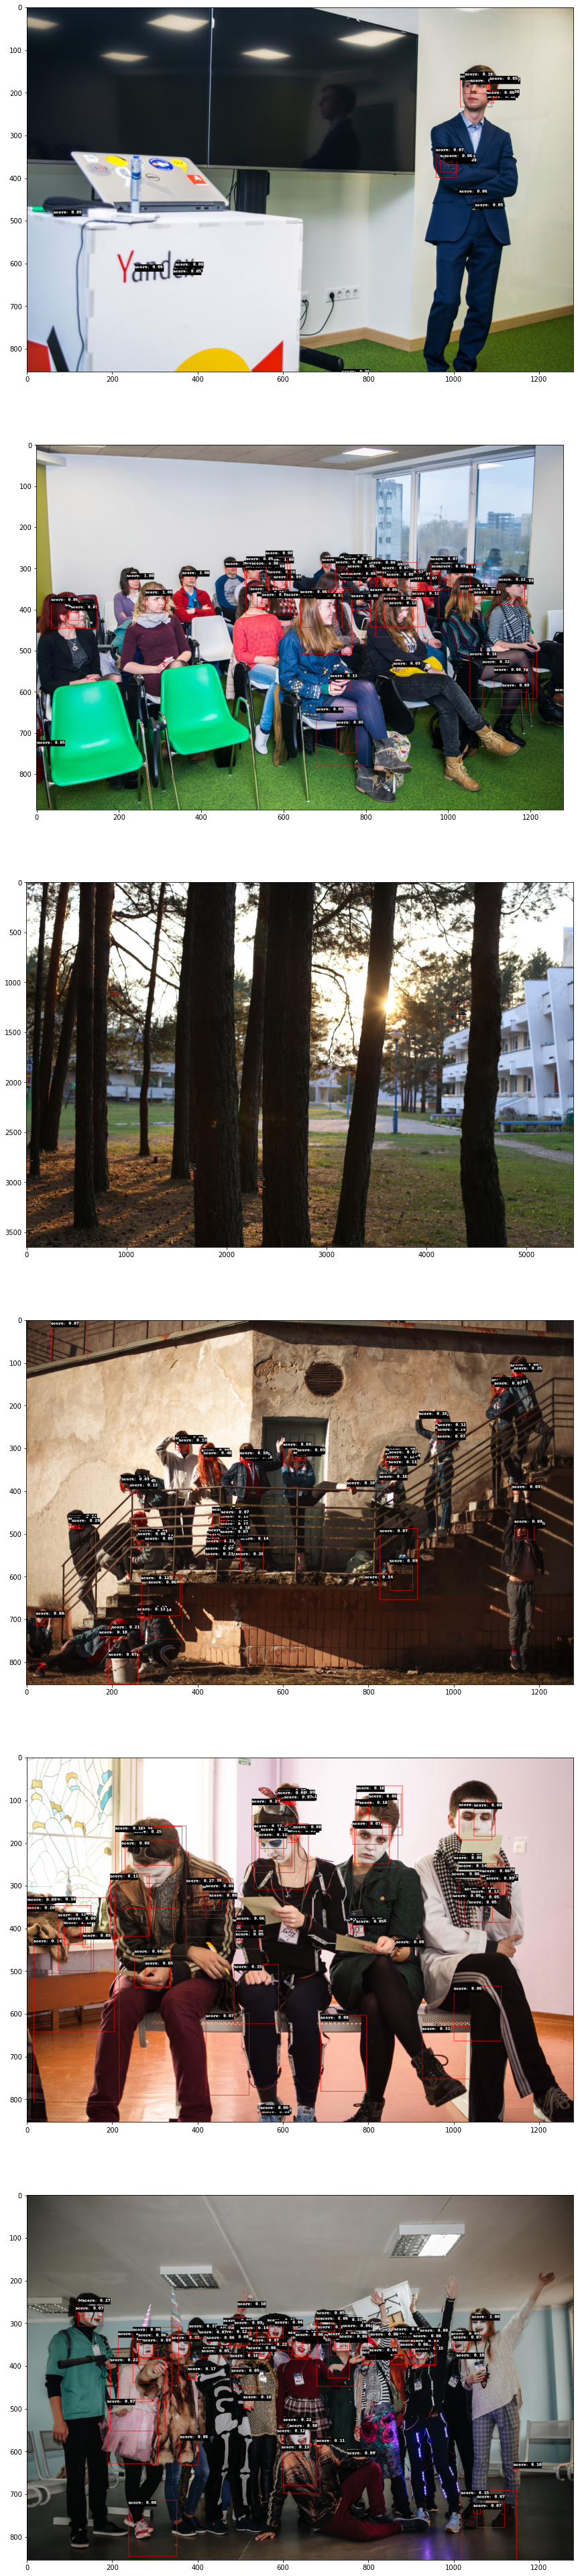

In [6]:
show_image_examples()

# **Немного выводов**
### (и интересных фактов)

мне не нравится то, как Адам рисует рамочки. Их слишком много. Как-то SGD в визуализации лучше себя показал. 
Да и по метрике у него было 37%, что не сильно хуже.

**Важный пункт, про который надо не забыть** : нужно понять, из-за чего получаются недетерминированные результаты (когда я запустида Adam-а в первый раз, то точность была 38%, когда перезапустила с новыми файлами - 4.7%, а тепеь=рь почти 40%, ыыыыыыыыыы)

Вывод: на данном этапе мне кажется, что достигнутая точность так себе, но добиться лучших результатов пока что не позволяют ресурсы :(

А ещё у меня график какой-то очень гладкий. В примере на гитхабе кривая была другой. Немного подозрительно, надо будет подумать над этим, мб я что-то не так сделала.

# **Пока не придумала название**

А здесь будет место, где пользователь может самостоятельно загрузить любое изображение и посмотреть на результат. (Вообще было бы прикольно сделать API-шку, где был бы какой-нибудь базовый интерфейс, позволяющий поиграться с сетками. Если вдруг у меня останется время, то показать такое на защите было бы прикольно:) ).

P.S. На данный момент этот блок не работает, тк у меня почему загружается не весь файл, а лишь 141 байт из 158 мб :(

In [ ]:
import os
import requests
from constants import *

model_name = 'faster-rcnn'

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params={'id': id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)


def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None


def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)


In [ ]:
download_file_from_google_drive(id, os.path.join(MODEL_PATH, model_name + '.pth'))

In [ ]:
from google.colab import files
from PIL import Image
from face_detection.transforms import test_transforms


def predict_for_user():

    download_file_from_google_drive(id, os.path.join(MODEL_PATH, model_name + '.pth'))
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = get_object_detection_model()
    model.to(device)
    model.load_state_dict(os.path.join(MODEL_PATH, model_name + '.pth'))
    model.eval()
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    image = Image.open(files.upload())
    img = test_transforms(image)


    with torch.no_grad():
        prediction = model([img.to(device)])
    
    show_predictions(image, prediction)

In [ ]:
predict_for_user()

# **Планы на будущее**

*(я больше писала это для себя, чтобы ничего не забыть, но вдруг вам тоже будет интересно :) ).*

План А на ближайщее будущее:

1. Добавить тестовую выборку, чтобы можно было понять, насколько хорошо обучилась модель, нужно ли пытаться увеличить объём обучающей выборки и тд... (+)

2. Провернуть то же самое для `RetinaNet` и метода Виолы-Джонса (реализация в cv)

3. Придумать, как это всё красиво структурировать, чтобы это было похоже на красивый проект, а не на рандомные куски кода.

План В (выполнять после плана А):

0. Обучить `Faster RCNN` и `RetinaNet` с 0. Можно взять готовые модели с параметром `pretrained=False` или посмотреть, какие там слои ( вроде как эта информация общедоступна) и прописать их явно. Может я не права, но оба способа выглядят, как одно и то же. 

1. (???) Построить свой метод Виолы-Джонса, используя классификатор из прошлой работы (Звучит как план энтузиаста, но наверное это реально сделать)

2. Сравнить результаты с нейронками из плана А.

3. Построить красивый визуал. Идея: взять пару картинок и прогнать каждое изображение через все сетки и вывести, чтобы посмотреть, как сетки справились с детекцией (таблицы с чиселками - это круто и очень по-научному, но как показал последний опыт, людям намного интереснее смотреть красивые картинки, чем таблички с кучей цифр:) ).


4. Убедиться, что всё работает, как надо, и раснести весь код по файлам, а в ноутбука оставить только визуал + таблички и прочие интересности.

5. Наслаждаться проделанной работой :)

# Ещё планы, чтобы не забыть:

1. Поиграться с transform   

2. не загружать датасет в оперативку. Вместо этого один раз отдельно всё загрузить, поделить на train и test, и сохранить в таком виде.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Mar 25 01:11:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    30W /  70W |   6106MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------